In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import networkx as nx

# JAX
import jax
import jax.numpy as jnp
import jraph
import numpy as np
import haiku as hk
import optax

# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

from model import VGAE
from dataset import draw_jraph_graph_structure

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
rng_key = jax.random.PRNGKey(42)

In [4]:
def plot_samps(draws, columns=4, rows=3, figsize = (19,12), ttl="CAR priors"):
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    _min, _max = np.amin(draws[0:columns*rows]), np.amax(draws[0:columns*rows])
    for r in range(rows):
        for c in range(columns):
            im = axs[r, c].imshow(draws[r*columns + c].reshape(num_y, num_x), 
                                  cmap='viridis', interpolation='none', #extent=[0,1,0,1], 
                                  origin='lower')
                                  #,vmin=_min, vmax=_max)
            axs[r, c].set_title("draw "+str(r*columns + c))  
            fig.colorbar(im, ax=axs[r, c])
    fig.suptitle(ttl, fontsize=16)
    plt.show()
    
def plot_truth_estimate(y_true, mean_post_pred_vae, ttl1="Ground truth", ttl2="CAR estimate"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    _min, _max = np.amin([y_true, mean_post_pred_vae]), np.amax([y_true, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2) 
    
def plot_truth_car_vae(y_true, mean_post_pred_car, mean_post_pred_vae, 
                       ttl1="Ground truth", ttl2="CAR estimate", ttl3="VAE estimate"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    _min = np.amin([y_true, mean_post_pred_car, mean_post_pred_vae])
    _max = np.amax([y_true, mean_post_pred_car, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_car.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2)
    
    im = axs[2].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[2])
    axs[2].set_title(ttl3)

In [5]:
# Grid.
k = 1
num_x = 15 * k
num_y = 10 * k

# Polygons.
pols = []
for j in range(num_y):
  for i in range(num_x):
    coords = [(i,j), (i+1, j), (i+1, j+1), (i, j+1), (i,j)]
    p = Polygon(coords)
    pols.append(p)
    
N = len(pols)

# Adjacency matrix.
A = np.zeros(shape=(N,N))
for i in range(N):
  for j in range(i+1,N):
    if (pols[i].intersection(pols[j]).length > 0):
      A[i,j] = 1
      A[j,i] = 1

# Number of neighbours.
d = A.sum(axis=0)
D = jnp.diag(d)
np.linalg.det(np.linalg.inv(D - A))

0.0

In [6]:
def CAR(args):
  A = args["A"]
  d = args["d"]
  D = jnp.diag(d)

  #alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))
  alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))

  Q = (D - alpha * A)
  car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))

In [7]:
args = {# data
  "d": d,
  "A": A,
  "batch_size": 600,
}

In [8]:
# CAR: prior predictive
rng_key, car_pred_rng = jax.random.split(rng_key)

car_predictive = Predictive(CAR, num_samples=args["batch_size"])
car_preds = car_predictive(car_pred_rng, args)
car_draws = car_preds['car']

In [9]:
car_draws.shape

(600, 150)

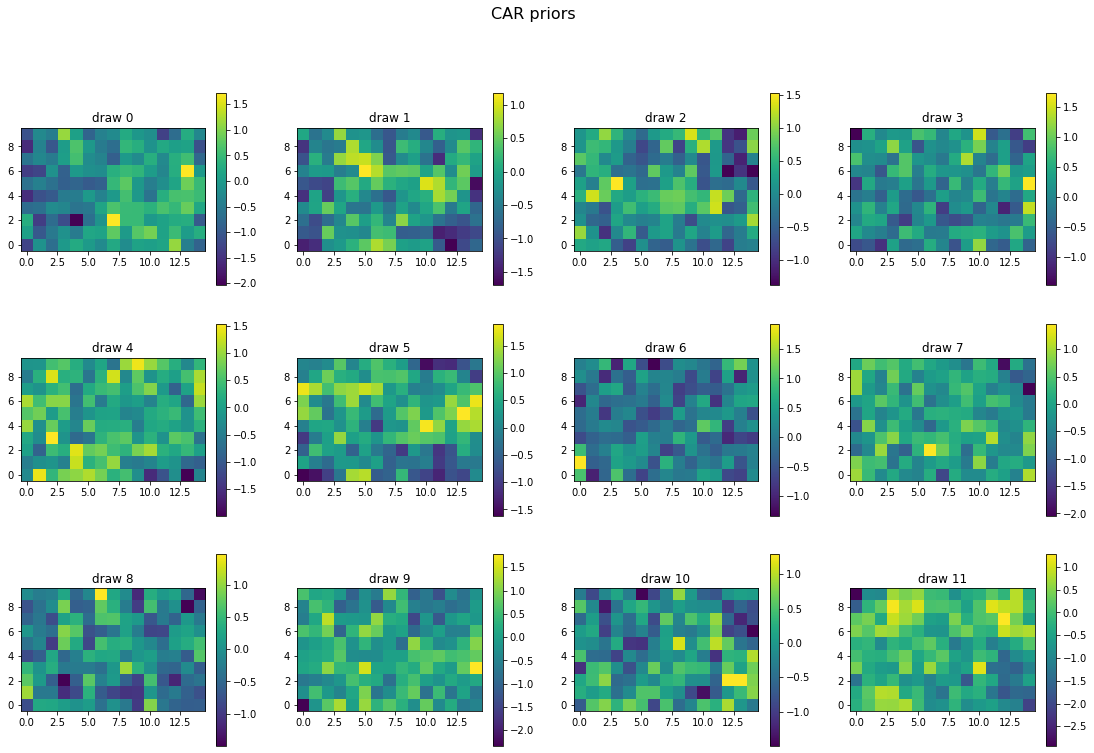

In [10]:
plot_samps(car_draws)

In [11]:
def create_grid_graph(adj_matrix: np.ndarray = None) -> jraph.GraphsTuple:
  if adj_matrix is None:
    adj_matrix = A
  G = nx.from_numpy_matrix(adj_matrix)

  edges = list(G.edges)
  edges += [(edge[1], edge[0]) for edge in edges]
  senders = jnp.asarray([edge[0] for edge in edges])
  receivers = jnp.asarray([edge[1] for edge in edges])

  return jraph.GraphsTuple(
    n_node = jnp.asarray([len(G.nodes)]),
    n_edge = jnp.asarray([len(edges)]),
    nodes=None,
    edges=None,
    globals=None,
    senders=senders, 
    receivers=receivers)

def get_car_draws_as_graph(car_draws: jnp.ndarray) -> jraph.GraphsTuple:
  graph = create_grid_graph()
  return graph._replace(nodes=car_draws)
  
dataset_graphs = []
dataset = []
for i in range(args['batch_size']):
  g = get_car_draws_as_graph(car_draws[i].reshape(-1, 1))
  dataset_graphs.append(g)
  dataset.append({
    'input_graph': g, 
    'target': g.nodes,
  })

split_idx = int(len(dataset) * 0.8)
train_dataset = dataset[:split_idx]
val_dataset = dataset[split_idx:]

print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))

Train size: 480
Validation size: 120


In [12]:
# Batching
train_dataset_graphs = dataset_graphs[:split_idx]
val_dataset_graphs = dataset_graphs[split_idx:]
train_graph_batch = jraph.batch(train_dataset_graphs)
val_graph_batch = jraph.batch(val_dataset_graphs)

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [13]:
# See graph statistics for a single graph
train_graph = train_dataset[0]['input_graph']
train_labels = train_graph.nodes

num_nodes = train_graph.n_node.item()
feat_matrix_dim = train_graph.nodes.shape
assert num_nodes == feat_matrix_dim[0], 'num_nodes != feat_matrix_dim[0]'
assert feat_matrix_dim == train_labels.shape, 'feat_matrix_dim != train_labels.shape'
print('Number of nodes:', num_nodes)
print('Feature matrix dim (n_node x n_feat):', feat_matrix_dim)
print('Targets shape:', train_labels.shape)

Number of nodes: 150
Feature matrix dim (n_node x n_feat): (150, 1)
Targets shape: (150, 1)


In [187]:
from typing import NamedTuple, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  hidden_dim: int = 500
  latent_dim: int = 200
  output_dim: int = train_labels.shape[1]
  learning_rate: float = 1e-2
  epochs: int = 200
  eval_frequency: int = 10
  num_nodes: int = num_nodes
  loss_fn: LossFun = loss.compute_mse_loss
  
wargs = Args(loss_fn=loss.compute_frobenius_loss)
print(wargs)

Args(hidden_dim=500, latent_dim=200, output_dim=1, learning_rate=0.01, epochs=200, eval_frequency=10, num_nodes=150, loss_fn=<function compute_frobenius_loss at 0x16a5821f0>)


In [188]:
rng_key, params_key = jax.random.split(rng_key)

# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=wargs.hidden_dim, 
                 latent_dim=wargs.latent_dim, 
                 output_dim=wargs.output_dim)(x))
optimizer = optax.adam(wargs.learning_rate)

In [189]:
from model import VGAEOutput
import loss
from loss import compute_kl_gaussian

@jax.jit
def loss_fn(params: hk.Params, 
            rng_key: jnp.ndarray,
            graph: jraph.GraphsTuple,
            targets: jnp.ndarray,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood_loss_fn = wargs.loss_fn
  log_likelihood = -log_likelihood_loss_fn(
    outputs.output.nodes, targets)
  kld = 1/num_nodes * jnp.mean(
    compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  return -elbo
  
@jax.jit
def update(
params: hk.Params,
rng_key: jnp.ndarray,
opt_state: optax.OptState,
graph: jraph.GraphsTuple,
targets: jnp.ndarray,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph, targets)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [190]:
# Initialize net with an arbitrary graph in dataset
init_graph = train_dataset[0]['input_graph']
params = net.init(params_key, init_graph)
opt_state = optimizer.init(params)

rng_key, train_rng = jax.random.split(rng_key)

train_losses = []
val_losses = []

start_time = time.time()
for epoch in range(wargs.epochs):    
  update_rng = jax.random.fold_in(train_rng, epoch)
  train_target_batch = train_graph_batch.nodes
    
  params, opt_state = update(params, update_rng, opt_state, 
                             train_graph_batch, train_target_batch)

  if epoch % wargs.eval_frequency == 0 or epoch == (wargs.epochs - 1):
    eval_rng = jax.random.fold_in(update_rng, epoch)
    train_loss = loss_fn(params, eval_rng, train_graph_batch, train_target_batch)
    train_losses.append(train_loss)
    
    print(f'epoch: {epoch}, train_loss: {train_loss:.3f}')

print(f'Total training time: {time.time() - start_time:.2f} s')

epoch: 0, train_loss: 3064.450
epoch: 10, train_loss: 1124.692
epoch: 20, train_loss: 172.321
epoch: 30, train_loss: 161.182
epoch: 40, train_loss: 140.927
epoch: 50, train_loss: 134.321
epoch: 60, train_loss: 133.013
epoch: 70, train_loss: 131.449
epoch: 80, train_loss: 130.810
epoch: 90, train_loss: 130.557
epoch: 100, train_loss: 130.462
epoch: 110, train_loss: 130.366
epoch: 120, train_loss: 130.130
epoch: 130, train_loss: 130.071
epoch: 140, train_loss: 129.958
epoch: 150, train_loss: 130.260
epoch: 160, train_loss: 129.825
epoch: 170, train_loss: 129.795
epoch: 180, train_loss: 129.649
epoch: 190, train_loss: 129.460
epoch: 199, train_loss: 129.562
Total training time: 261.01 s


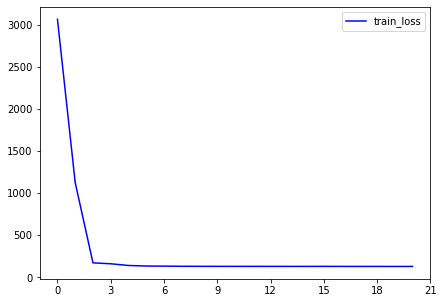

In [191]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize=(7, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(train_losses, label='train_loss', color='blue')
plt.legend()
plt.show()

In [192]:
rng_key, eval_rng = jax.random.split(rng_key)

val_target_batch = val_graph_batch.nodes
val_loss = loss_fn(params, eval_rng, val_graph_batch, val_target_batch)
print(f'Evaluation loss: {val_loss:.3f}')

Evaluation loss: 66.237


In [193]:
from model import prior_decode
from functools import partial

decoder_params = {
  'decoder_hidden': params['vgae/decoder_hidden'],
  'decoder_output': params['vgae/decoder_output'],
}

decoder_net_fn = partial(prior_decode, hidden_dim=wargs.hidden_dim, output_dim=wargs.output_dim)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

In [194]:
rng_key, z_rng = jax.random.split(rng_key)

rng_key, *sample_rngs = jax.random.split(rng_key, args['batch_size']+1)

vae_draws = []
for idx in range(args['batch_size']):
  z_rng_idx = jax.random.fold_in(z_rng, idx)
  z = jax.random.normal(z_rng_idx, shape=(wargs.num_nodes, wargs.latent_dim))
  z_graph = create_grid_graph()._replace(nodes=z)  # this step assumes only node features are used.
  out_graph = decoder_net.apply(decoder_params, z_graph)
  vae_draws.append(out_graph.nodes)

vae_draws = jnp.squeeze(jnp.asarray(vae_draws))
assert vae_draws.shape == car_draws.shape

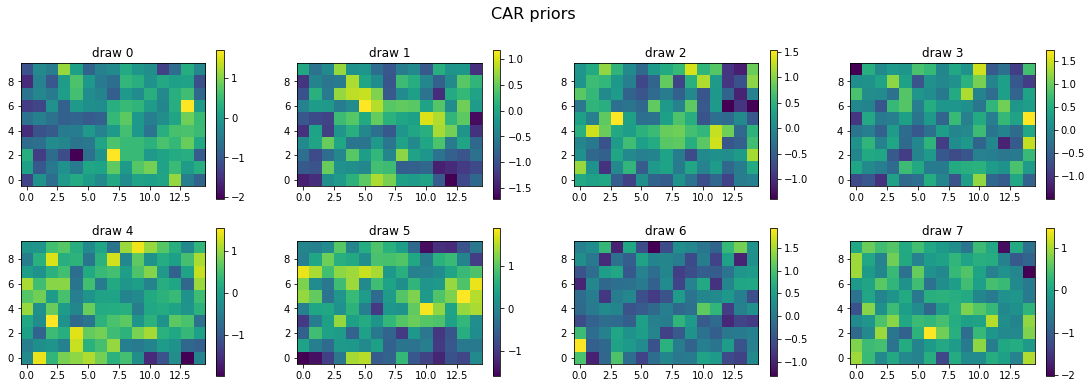

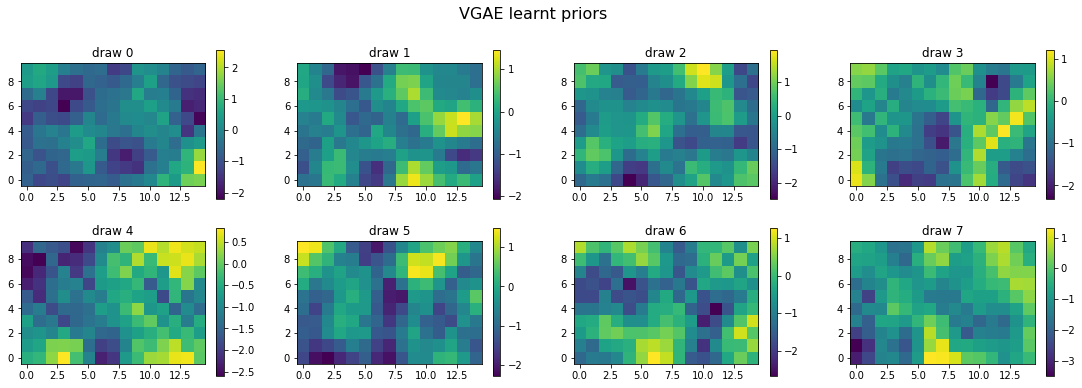

In [195]:
plot_samps(car_draws, rows=2, figsize=(19, 6))
plot_samps(vae_draws, rows=2, figsize=(19, 6), ttl='VGAE learnt priors')

In [196]:
print(wargs)

Args(hidden_dim=500, latent_dim=200, output_dim=1, learning_rate=0.01, epochs=200, eval_frequency=10, num_nodes=150, loss_fn=<function compute_frobenius_loss at 0x16a5821f0>)


### Inference on observed data with VGAE-CAR

In [197]:
args['decoder_params'] = decoder_params

In [198]:
def CAR_model(args, y=None, alpha=None, noise=None):
    
    A = args["A"]
    d = args["d"]
    D = jnp.diag(d)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha * A)
    
    car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))
    car_samples = numpyro.deterministic('car_samples', car)
    
    if y is None: # during prediction
        numpyro.sample("y_pred", dist.Normal(car, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car, noise), obs=y)

In [199]:
# generate ground truth - fix alpha
rng_key, rng_key_truth = jax.random.split(rng_key)
car_predictive = Predictive(CAR_model, num_samples=1)
car_preds = car_predictive(rng_key_truth, args, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

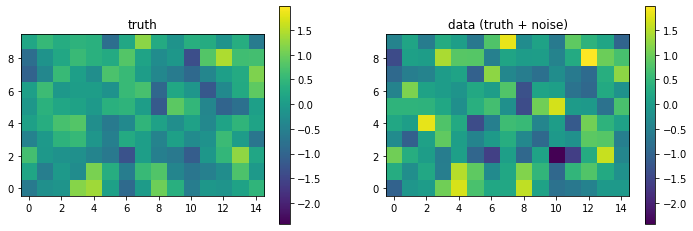

In [200]:
plot_truth_estimate(y_truth, y_data, ttl1="truth", ttl2="data (truth + noise)")

In [201]:
args['hidden_dim'] = wargs.hidden_dim
args['latent_dim'] = wargs.latent_dim
args['output_dim'] = wargs.output_dim
args['train_graph'] = train_graph
args['n_node'] = wargs.num_nodes
args['decoder_net'] = decoder_net

In [202]:
z = jax.random.normal(z_rng_idx, shape=(wargs.num_nodes, wargs.latent_dim))
z_graph = create_grid_graph()._replace(nodes=z)  # this step assumes only node features are used.
out_graph = decoder_net.apply(decoder_params, z_graph)

In [203]:
def VAE_model(args, y=None, noise=None):
    z = numpyro.sample("z", dist.Normal(0, 1).expand([args['n_node'], args['latent_dim']]))
    z_graph = create_grid_graph()._replace(nodes=z)  # this step assumes only node features are used.
    
    decoder_params = args["decoder_params"] 
    car_vae = numpyro.deterministic(
        "vae_car", decoder_net.apply(decoder_params, z_graph).nodes.T)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample("y_pred", dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car_vae, noise), obs=y)

In [204]:
# VAE-CAR: prior predictive
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(VAE_model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, args)
pred_obs = prior_predictions['vae_car']

# Take mean over axis=0 (num_samples) and then over axis=1 (batch_size)
mean_prior_pred_vae = np.mean(pred_obs, axis=(0, 1))
# Original VAE used: mean_prior_pred_vae = np.mean(pred_obs, axis=0)

hpdi_prior_pred_vae = hpdi(pred_obs, 0.89)

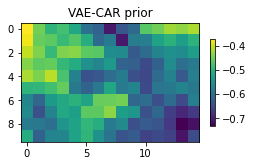

In [205]:
plt.figure()
plt.imshow(mean_prior_pred_vae.reshape(num_y, num_x)) 
plt.colorbar(shrink=0.4)
plt.title("VAE-CAR prior")
plt.show()

In [206]:
# inference
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(VAE_model, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng_key, rng_key_infer = jax.random.split(rng_key)
mcmc.run(rng_key_infer, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [05:00<00:00,  9.99it/s, 31 steps of size 1.17e-01. acc. prob=0.84]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
         noise      0.66      0.05      0.65      0.58      0.73   1323.43      1.00
  vae_car[0,0]     -0.31      0.38     -0.32     -0.89      0.36   2799.87      1.00
  vae_car[0,1]     -0.23      0.36     -0.23     -0.80      0.36   2719.36      1.00
  vae_car[0,2]     -0.07      0.35     -0.08     -0.64      0.51   2871.40      1.00
  vae_car[0,3]      0.69      0.37      0.69      0.11      1.28   2509.74      1.00
  vae_car[0,4]      1.04      0.37      1.04      0.45      1.65   2881.86      1.00
  vae_car[0,5]      0.78      0.36      0.77      0.19      1.37   3068.29      1.00
  vae_car[0,6]      0.33      0.37      0.34     -0.25      0.95   3277.91      1.00
  vae_car[0,7]      0.51      0.36      0.50     -0.11      1.05   2569.36      1.00
  vae_car[0,8]      0.72      0.37      0.72      0.12      1.36   2509.32      1.00
  vae_car[0,9]      0.32      0.38      0.33     -0.25      0.97

In [207]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 314 s
Average ESS for all CAR effects : 2670


In [208]:
mcmc_samples.keys()

dict_keys(['noise', 'vae_car', 'z'])

In [209]:
# posterior predictive
rng_key, rng_key_ = jax.random.split(rng_key)
posterior_predictive = Predictive(VAE_model, mcmc_samples)
posterior_predictions = posterior_predictive(rng_key_, args)
post_obs = posterior_predictions['vae_car']

# Take mean over axis=0 (num_samples) and then over axis=1 (batch_size)
mean_post_pred_vae = np.mean(post_obs, axis=(0, 1))
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

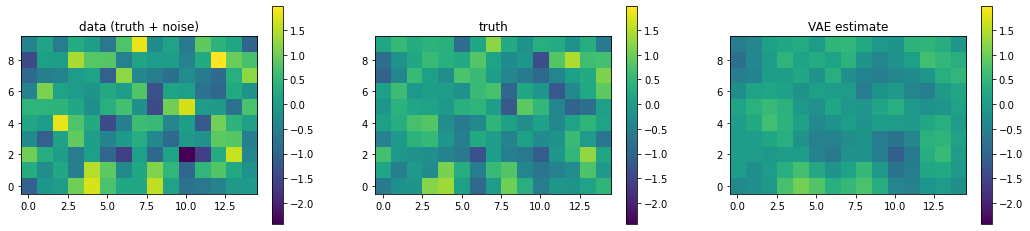

In [210]:
plot_truth_car_vae(y_data, y_truth, 
                   mean_post_pred_vae, 
                   ttl1="data (truth + noise)", ttl2="truth", ttl3="VAE estimate")

Text(0, 0.5, 'VAE post. predictive')

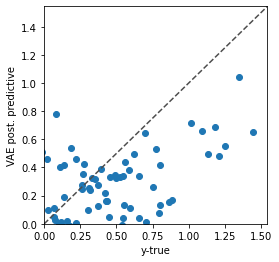

In [212]:
mx = np.max([y_truth, mean_post_pred_vae])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(y_truth, mean_post_pred_vae)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("y-true")
plt.ylabel("VAE post. predictive")

In [213]:
MSE_vae = np.mean((y_truth -  mean_post_pred_vae)**2)
print(MSE_vae)

0.177088


In [214]:
print(wargs)

Args(hidden_dim=500, latent_dim=200, output_dim=1, learning_rate=0.01, epochs=200, eval_frequency=10, num_nodes=150, loss_fn=<function compute_frobenius_loss at 0x16a5821f0>)
